In [1]:
# Do the necessary imports
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile, assemble, execute
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.extensions import Initialize
from qiskit.quantum_info import random_statevector

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# 1 Qubit Gate - Generate a random state
def random_state_gate():
    psi = random_statevector(2)
    gate = Initialize(psi)
    gate.label = "init"
    return gate

# N Qubit Gate - Reverse a gate
def reverse_gate(gate):
    inverse_gate = gate.gates_to_uncompute()
    inverse_gate.label = "disentangler"
    return inverse_gate

In [3]:
def create_bell_pair(qc, a, b):
    qc.h(a)    # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target
    
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)
    
def bob_gates(qc, a, b, c):
    qc.cx(b, c)
    qc.cz(a, c)

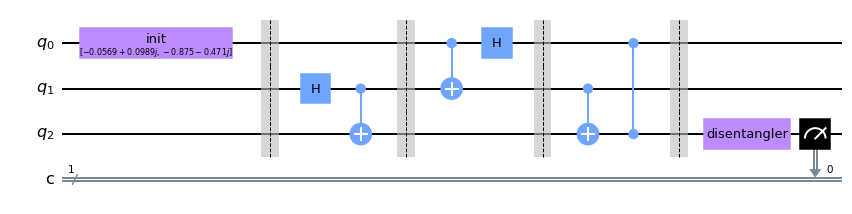

In [4]:
# Main gates to work with
init_gate = random_state_gate()    # random state
dis_gate = reverse_gate(init_gate) # gates to reverse random state

# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")  # Protocol uses 3 qubits
c = ClassicalRegister(1, name="c") # and 1 classical bits
qc = QuantumCircuit(qr, c)

# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)
qc.barrier()

# Bob decodes qubits
bob_gates(qc, 0, 1, 2)
qc.barrier()

# Finally, lets reverse the qubit we got to see if its correct
qc.append(dis_gate, [2])
qc.measure(2, c)

# Display the circuit
qc.draw()

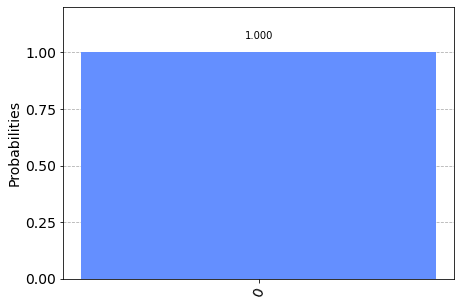

In [5]:
# Simulate and plot results
aer_simulator = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, aer_simulator)
qobj = assemble(transpiled_qc)
results = aer_simulator.run(qobj).result().get_counts()

# Actual quantum computer to get results
#provider = IBMQ.load_account()
#backend = provider.get_backend('ibmq_manila')
#results = execute(qc,backend,shots=1024).result().get_counts()

plot_histogram(results)